# Functional Cross-Border Region Maps

In [1]:
from adjustText import adjust_text
import contextily as ctx
import csv
from datetime import datetime
import db_connection as db_con
import descartes
from descartes import PolygonPatch
import folium
from functools import partial
import geojson
import geopandas as gpd
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
import io
from io import StringIO
import json
from matplotlib import cm
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.patches as mpatches
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
import operator
import os
import pandas as pd
import psycopg2
import psycopg2.extras as extras
import seaborn as sns
from shapely import wkt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from sqlalchemy import create_engine, func, distinct
import sys
import tempfile

In [2]:
# Import credential and connection settings
db_name = db_con.db_name
db_username = db_con.db_username
db_host = db_con.db_host
db_port = db_con.db_port
db_pwd = db_con.db_pwd
engine_string = f"postgresql://{db_username}:{db_pwd}@{db_host}:{db_port}/{db_name}"
db_engine = create_engine(engine_string)

In [3]:
# Color setings
cmap = mpl.cm.get_cmap('Blues')
border_color = cmap(0.75, 0.7)

cmap = mpl.cm.get_cmap('Reds')
color_map = [cmap(0.05, 1), cmap(.25, 1), cmap(0.5, 1), cmap(0.75, 1), cmap(1, 1)]

In [4]:
def load_lines(table_name):
    query = f'SELECT geometry,user_id,dest_country,orig_time,dest_time,duration,post_region,dest_region,region_move,cb_move,distance_km,row_id,country_code FROM {table_name}'
    lines_df = db_con.read_sql_inmem_uncompressed(query, db_engine)
    # Apply wkt
    lines_df['geometry'] = lines_df['geometry'].apply(wkt.loads)
    # Convert to GeoDataFrame
    lines_df_gdf = gpd.GeoDataFrame(lines_df, geometry='geometry')
    # CRS
    lines_df_gdf.crs = "EPSG:4326"
    # Delete dataframe
    del lines_df
    # Convert timestamps
    lines_df_gdf['orig_time'] = lines_df_gdf['orig_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
    lines_df_gdf['dest_time'] = lines_df_gdf['dest_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
    # Add month
    lines_df_gdf['month'] = lines_df_gdf['dest_time'].apply(lambda x: x.month)
    lines_df_gdf['yearmonth'] = lines_df_gdf['dest_time'].apply(lambda x: int(str(x.year)+str(x.month).zfill(2)))
    # Add day of week
    lines_df_gdf['orig_day_of_week'] = lines_df_gdf['orig_time'].apply(lambda x: x.dayofweek)
    lines_df_gdf['dest_day_of_week'] = lines_df_gdf['dest_time'].apply(lambda x: x.dayofweek)
    print(f"[INFO] - {table_name} loaded")
    return lines_df_gdf

In [5]:
baseline_1 = load_lines("nordic_2017_lines")
baseline_2 = load_lines("nordic_2018_lines")
baseline_3 = load_lines("pre_covid_lines")
covid_lines = load_lines("post_covid_lines")

[INFO] - nordic_2017_lines loaded
[INFO] - nordic_2018_lines loaded
[INFO] - pre_covid_lines loaded
[INFO] - post_covid_lines loaded


In [6]:
# Weighting
w1 = np.array([1.000, 0.985944568893574, 1.14987052049461, 1.10260594796902])
baseline_1['weight'] = w1[0]
baseline_2['weight'] = w1[1]
baseline_3['weight'] = w1[2]
covid_lines['weight'] = w1[3]

In [7]:
# Combining baselines
all_baseline = baseline_1
all_baseline = all_baseline.append(baseline_2)
all_baseline = all_baseline.append(baseline_3)

In [8]:
# Cities to plot
cities_list = ['Copenhagen, Denmark','Malmö, Sweden','Oslo, Norway','Helsinki, Finland','Stockholm, Sweden','Tornio, Finland','Haparanda, Sweden','Göteborg, Sweden', 'Tromsø, Norway','Bergen, Norway', 'Århus, Denmark','Stavanger,Norway','Reykjavik, Iceland', 'Trondheim, Norway', ' Vasa, Bangatan, Finland','Umeå, Sweden','Oulu, Finland','Sundsvall, Sweden','Turku, Finland', 'Kiruna, Sweden','Ålborg, Denmark','Luleå, Sweden', 'Rovaniemi, Finland', 'Strömstad, Sweden', 'Halden, Norway', 'Alta, Norway']
df = pd.DataFrame(cities_list)
geolocator = Nominatim(user_agent="haavard")
geocode2 = partial(geolocator.geocode, language="en")
cities_df = geocode(df[0], provider='nominatim', user_agent='haavardaa', timeout=4)
cities_df = cities_df.to_crs(epsg=3035)
cities_df['x'] = cities_df['geometry'].apply(lambda point: point.x)
cities_df['y'] = cities_df['geometry'].apply(lambda point: point.y)
cities_df['label'] = cities_df['address'].apply(lambda x: geocode2(x))
cities_df['label'] = cities_df['label'].apply(lambda x: list(str(x).split(","))[0])
cities_df['label'] = cities_df['label'].apply(lambda x: list(str(x).split(" "))[0])
del df

In [9]:
## Nordic Countries
nordic_and_baltics_geopackage_fp = 'NordicBalticsIceland.gpkg'
nordics_and_balt = gpd.read_file(nordic_and_baltics_geopackage_fp)
nordics = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('DK|FI|NO|SE|IS')]
regions_fp = 'NUTS2.gpkg'
regions = gpd.read_file(regions_fp)
regions = regions.to_crs(epsg=3035)

/home/aagesenh/anaconda3/envs/gis/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [10]:
def functional_area_regions(region_one, region_two, lines_gdf, title):
    regions_string = f"{region_one}-{region_two}|{region_two}-{region_one}"
    all_lines = lines_gdf[lines_gdf['region_move'].str.match(regions_string)]
    if title == 'All Baseline Years':
        title_string = "a) BL AVG"
    else:
        title_string = "b) COVID-19"
    all_lines['start_point'] = all_lines.apply(lambda x: [y for y in x['geometry'].coords][0], axis=1)
    all_lines['end_point'] = all_lines.apply(lambda x: [y for y in x['geometry'].coords][1], axis=1)
    # Country one
    one_starts = all_lines[all_lines['post_region'] == region_one]
    one_starts = one_starts[['dest_region','post_region', 'start_point','row_id','weight']]
    one_starts['geometry'] = one_starts['start_point'].apply(lambda x: Point(x[0],x[1]))
    one_ends = all_lines[all_lines['dest_region'] == region_one]
    one_ends = one_ends[['dest_region','post_region', 'end_point','row_id','weight']]
    one_ends['geometry'] = one_ends['end_point'].apply(lambda x: Point(x[0],x[1]))
    one = one_starts.append(one_ends)
    del one_starts
    del one_ends
    one = one.set_geometry('geometry')
    one.crs = "EPSG:4326"
    one = one.to_crs(epsg=3035)
    # Country two
    two_starts = all_lines[all_lines['post_region'] == region_two]
    two_starts = two_starts[['dest_region','post_region', 'start_point','row_id','weight']]
    two_starts['geometry'] = two_starts['start_point'].apply(lambda x: Point(x[0],x[1]))
    two_ends = all_lines[all_lines['dest_region'] == region_two]
    two_ends = two_ends[['dest_region','post_region', 'end_point','row_id','weight']]
    two_ends['geometry'] = two_ends['end_point'].apply(lambda x: Point(x[0],x[1]))
    two = two_starts.append(two_ends)
    del two_starts
    del two_ends
    two = two.set_geometry('geometry')
    two.crs = "EPSG:4326"
    two = two.to_crs(epsg=3035)

    # Set up total bounds
    region_one_country = region_one[:2]
    region_two_country = region_two[:2]
    country_one_clipping = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match(region_one_country)]
    country_two_clipping = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match(region_two_country)]
    region_one_clipping = regions[regions['NUTS_ID'].str.match(region_one)]
    region_two_clipping = regions[regions['NUTS_ID'].str.match(region_two)]
    total_bounds_gdf = region_one_clipping.append(region_two_clipping)

    # Plot
    f, ax = plt.subplots(ncols=1, figsize=(20, 16))
    total_bounds_gdf.plot(ax=ax, color=None)
    on = sns.kdeplot(x=one['geometry'].x,y= one['geometry'].y, weights=one['weight'], shade=True, cmap='Reds',alpha=0.9, ax=ax, levels=[0.05,0.25,0.50,0.75,1])
    on.collections[0].set_facecolor(cmap(0.05,0))
    on.collections[-1].set_lw([0])
    on.collections[1].set_facecolor(color_map[0])
    on.collections[2].set_facecolor(color_map[1])
    on.collections[3].set_facecolor(color_map[2])
    on.collections[4].set_facecolor(color_map[3])
    # Clipping
    a = PolygonPatch(country_one_clipping['geometry'].iloc[0],transform=ax.transData)
    p = PolygonPatch(region_one_clipping['geometry'].iloc[0],transform=ax.transData)
    ctx.add_basemap(ax=ax,crs = total_bounds_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels) # 3
    num_coll = len(ax.collections)
    for col in ax.collections[:num_coll]:
        col.set_clip_path(p)
    
    tw = sns.kdeplot(x=two['geometry'].x,y= two['geometry'].y, weights=two['weight'], shade=True, cmap='Reds',alpha=0.9, ax=ax, levels=[0.05,0.25,0.50,0.75,1])
    tw.collections[num_coll+0].set_facecolor(color_map[0])
    tw.collections[num_coll+1].set_facecolor(color_map[1])
    tw.collections[num_coll+2].set_facecolor(color_map[2])
    tw.collections[num_coll+3].set_facecolor(color_map[3])
    # Clipping
    b = PolygonPatch(country_two_clipping['geometry'].iloc[0],transform=ax.transData)
    q = PolygonPatch(region_two_clipping['geometry'].iloc[0],transform=ax.transData)
    for col in ax.collections[num_coll:]:
        col.set_clip_path(q)

    df = pd.DataFrame(columns = ['class','geometry','region'])
    classlist = [95,75,50,25,95,75,50,25]
    i = 0
    for col in tw.collections[1:5]:
        paths = []
        # Loop through all polygons that have the same intensity level
        for contour_path in col.get_paths(): 
            # Create the polygon for this intensity level
            # The first polygon in the path is the main one, the following ones are "holes"
            for ncp,cp in enumerate(contour_path.to_polygons()):
                x = cp[:,0]
                y = cp[:,1]
                new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
                if ncp == 0:
                    poly = new_shape
                else:
                    # Remove the holes if there are any
                    poly = poly.difference(new_shape)
                    # Can also be left out if you want to include all rings
            paths.append(poly)
        mult = MultiPolygon(paths)
        mult = mult.intersection(region_one_clipping['geometry'].iloc[0])
        df.at[i,'class'] = classlist[i]
        df.at[i,'geometry'] = mult
        df.at[i,'region'] = region_one
        i+=1

    for col in tw.collections[5:]:
        paths = []
        # Loop through all polygons that have the same intensity level
        for contour_path in col.get_paths(): 
            # Create the polygon for this intensity level
            # The first polygon in the path is the main one, the following ones are "holes"
            for ncp,cp in enumerate(contour_path.to_polygons()):
                x = cp[:,0]
                y = cp[:,1]
                new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
                if ncp == 0:
                    poly = new_shape
                else:
                    # Remove the holes if there are any
                    poly = poly.difference(new_shape)
                    # Can also be left out if you want to include all rings
            paths.append(poly)
        mult = MultiPolygon(paths)
        mult = mult.intersection(region_two_clipping['geometry'].iloc[0])
        df.at[i,'class'] = classlist[i]
        df.at[i,'geometry'] = mult
        df.at[i,'region'] = region_two
        i+=1
    ctx.add_basemap(ax=ax,crs = total_bounds_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels) # 3
    ax.set_axis_off()

    xlim = ([total_bounds_gdf.total_bounds[0],  total_bounds_gdf.total_bounds[2]])
    ylim = ([total_bounds_gdf.total_bounds[1],  total_bounds_gdf.total_bounds[3]])
    # Ploting
    r = region_one_clipping.plot(ax=ax,facecolor="none", edgecolor=border_color, zorder=5, transform=ax.transData)
    s = region_two_clipping.plot(ax=ax,facecolor="none", edgecolor=border_color, zorder=5, transform=ax.transData)
    cities = gpd.sjoin(cities_df,total_bounds_gdf, how='inner', op='within')
    cities.plot(ax=ax,color='black',markersize=10, zorder=6)
    cit = cities.plot(ax=ax,color='black',markersize=10, zorder=6)
    texts = [cit.text(cities['x'].iloc[i], cities['y'].iloc[i], cities['label'].iloc[i], ha='center', va='center',fontsize=18,zorder=7) for i in range(len(cities))]
    adjust_text(texts)
    ctx.add_basemap(ax=ax,crs = total_bounds_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels) # 3
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()
    # Coloring
    patch_one = mpatches.Patch(color=color_map[0], label='95%')
    patch_two = mpatches.Patch(color=color_map[1], label='75%')
    patch_three = mpatches.Patch(color=color_map[2], label='50%')
    patch_four = mpatches.Patch(color=color_map[3], label='25%')
    plt.legend(handles=[patch_one,patch_two,patch_three,patch_four],title="Share of Travels")
    f.suptitle(title_string,fontsize=42)

    file_string = f"{title}_{region_one}_{region_two}_functional_area.JPEG"
    geo = gpd.GeoDataFrame(df, geometry='geometry', crs = two.crs)
    geo['area'] = geo['geometry'].area
    save_string = f"imgs/functional_area/regional/{title}_{region_one}_{region_two}.gpkg"
    #geo.to_file(save_string, driver='GPKG')
    return plt

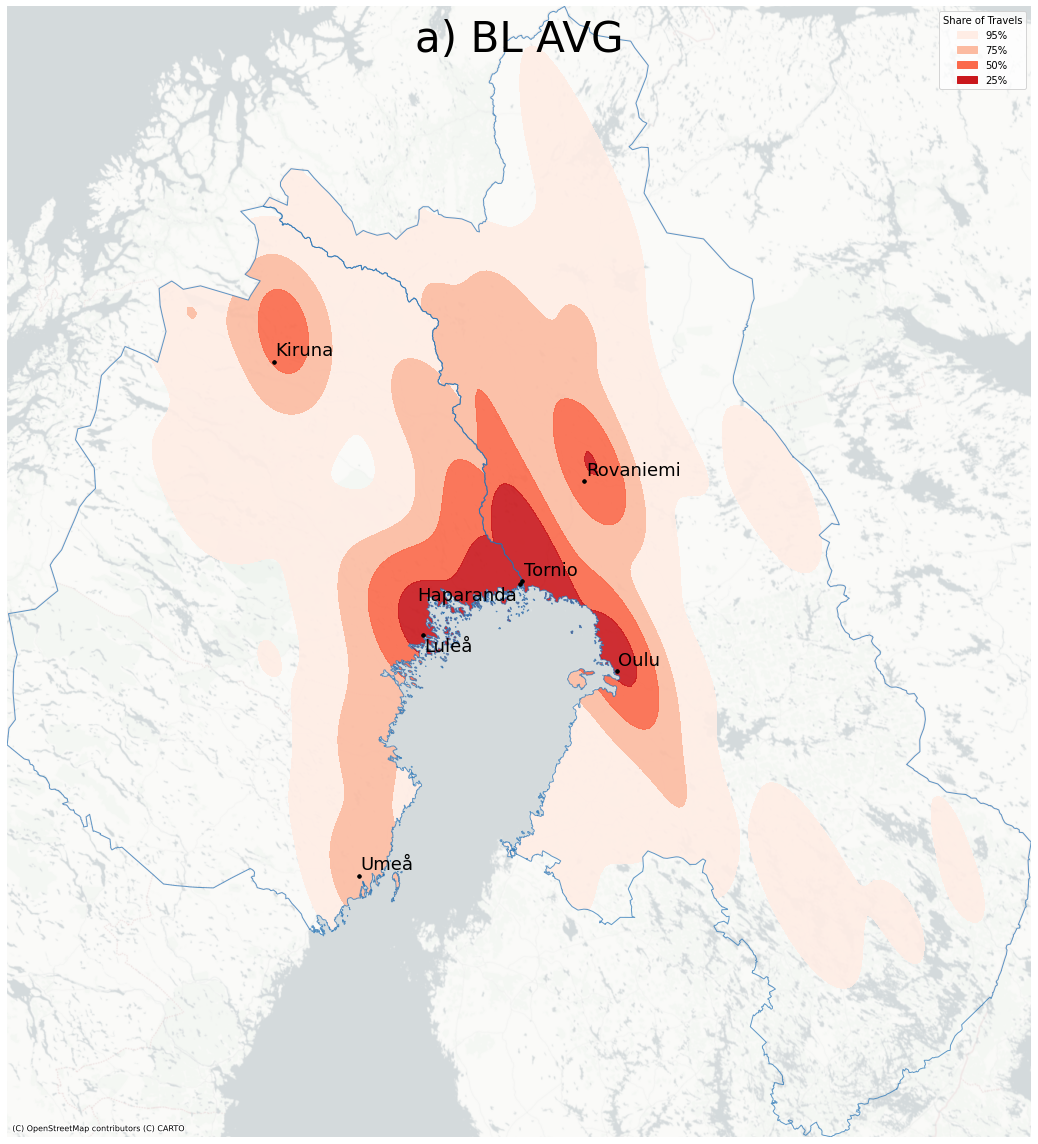

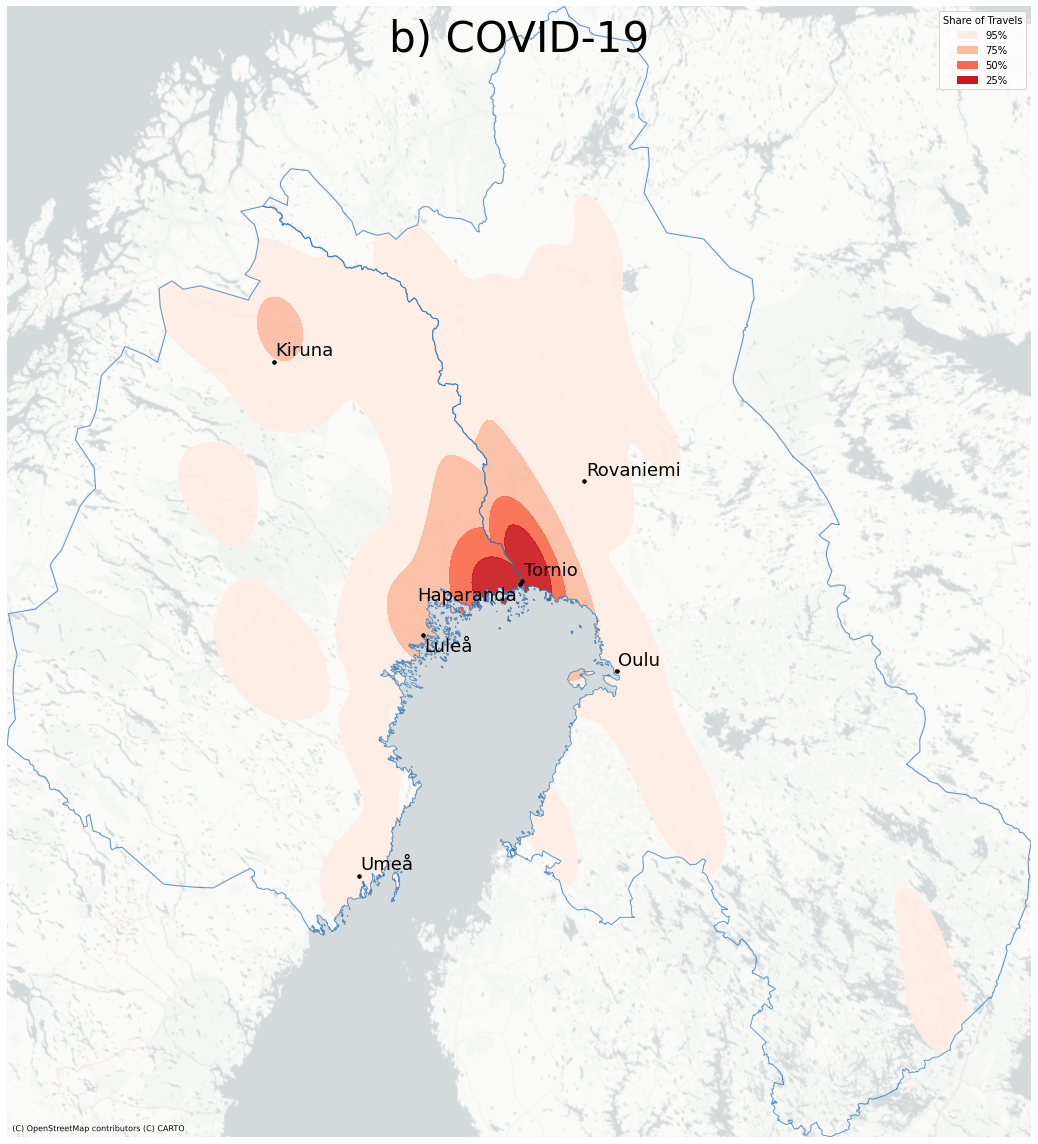

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'
functional_area_regions('SE33','FI1D',all_baseline,'All Baseline Years').show()
functional_area_regions('SE33','FI1D',covid_lines,'COVID-19').show()